# Fake News Detection with DistilBERT

In this notebook, we will finetune DistilBERT, a lightweight transformer model, for fake news detection using the FakeNewsNet dataset (CSV format). We'll compare its performance with TinyBERT to determine which model is better suited for your Django application.

## Overview

1. Install dependencies (PyTorch-only, avoiding TensorFlow/Keras conflicts)
2. Load and explore the FakeNewsNet CSV data
3. Preprocess the text data
4. Implement DistilBERT for sequence classification
5. Train and evaluate the model
6. Compare with TinyBERT
7. Export the model for Django integration

## 2. Import Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EvalPrediction
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc
import json
import re
import psutil
from tqdm.auto import tqdm

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.6.0
CUDA available: False


## 3. Load and Explore the FakeNewsNet Dataset (CSV Format)

In [3]:
# Load the dataset
try:
    fake_news = pd.read_csv("./fake-news-net/Fake.csv")
    real_news = pd.read_csv("./fake-news-net/True.csv")
    
    print(f"Fake news dataset shape: {fake_news.shape}")
    print(f"Real news dataset shape: {real_news.shape}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure the CSV files are in the correct location.")

Fake news dataset shape: (23481, 4)
Real news dataset shape: (21417, 4)


In [4]:
# Explore the datasets
print("Fake news dataset columns:")
print(fake_news.columns.tolist())

print("\nReal news dataset columns:")
print(real_news.columns.tolist())

# Check for missing values
print("\nMissing values in fake news dataset:")
print(fake_news.isnull().sum())

print("\nMissing values in real news dataset:")
print(real_news.isnull().sum())

Fake news dataset columns:
['title', 'text', 'subject', 'date']

Real news dataset columns:
['title', 'text', 'subject', 'date']

Missing values in fake news dataset:
title      0
text       0
subject    0
date       0
dtype: int64

Missing values in real news dataset:
title      0
text       0
subject    0
date       0
dtype: int64


In [5]:
# Display a few examples from each dataset
print("Sample from fake news dataset:")
display(fake_news.head(2))

print("\nSample from real news dataset:")
display(real_news.head(2))

Sample from fake news dataset:


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"



Sample from real news dataset:


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


In [6]:
# Prepare combined dataset with labels
# Add a label column (1 for fake, 0 for real)
fake_news['label'] = 1
real_news['label'] = 0

# Combine the datasets
df = pd.concat([fake_news, real_news], ignore_index=True)

# Shuffle the data
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

print(f"Combined dataset shape: {df.shape}")
print("\nLabel distribution:")
print(df['label'].value_counts())

Combined dataset shape: (44898, 5)

Label distribution:
label
1    23481
0    21417
Name: count, dtype: int64


## 4. Data Preprocessing and Visualization

In [7]:
# Check for text columns (title, text, etc.)
text_columns = df.select_dtypes(include=['object']).columns.tolist()
print(f"Text columns: {text_columns}")

# Let's identify which columns contain the article text and title
# Assuming the dataset has columns like 'title' and 'text'
title_col = 'title' if 'title' in df.columns else None
text_col = 'text' if 'text' in df.columns else None

# If the columns have different names, try to guess based on content
if title_col is None or text_col is None:
    for col in text_columns:
        # Sample the first few values to determine type of content
        sample_lengths = df[col].str.len().head(10)
        avg_length = sample_lengths.mean()
        
        if avg_length < 100 and title_col is None:
            title_col = col
            print(f"Using '{col}' as title column")
        elif avg_length > 100 and text_col is None:
            text_col = col
            print(f"Using '{col}' as text column")

# If we still don't have a text column, use the longest text column
if text_col is None:
    avg_lengths = {col: df[col].str.len().mean() for col in text_columns}
    text_col = max(avg_lengths, key=avg_lengths.get)
    print(f"Selected '{text_col}' as text column based on length")

Text columns: ['title', 'text', 'subject', 'date']


In [8]:
# Basic text preprocessing function
def preprocess_text(text):
    """Clean and normalize text data"""
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Combine title and text if both are available
if title_col and text_col:
    df['combined_text'] = df[title_col].fillna('') + ' ' + df[text_col].fillna('')
elif title_col:
    df['combined_text'] = df[title_col].fillna('')
else:
    df['combined_text'] = df[text_col].fillna('')

# Apply preprocessing
df['processed_text'] = df['combined_text'].apply(preprocess_text)

# Check for empty texts after preprocessing
empty_texts = df['processed_text'].apply(lambda x: len(x.strip()) == 0).sum()
print(f"Number of empty texts after preprocessing: {empty_texts}")

# Remove empty texts if any
if empty_texts > 0:
    df = df[df['processed_text'].apply(lambda x: len(x.strip()) > 0)].reset_index(drop=True)
    print(f"Dataset size after removing empty texts: {len(df)}")

Number of empty texts after preprocessing: 9
Dataset size after removing empty texts: 44889


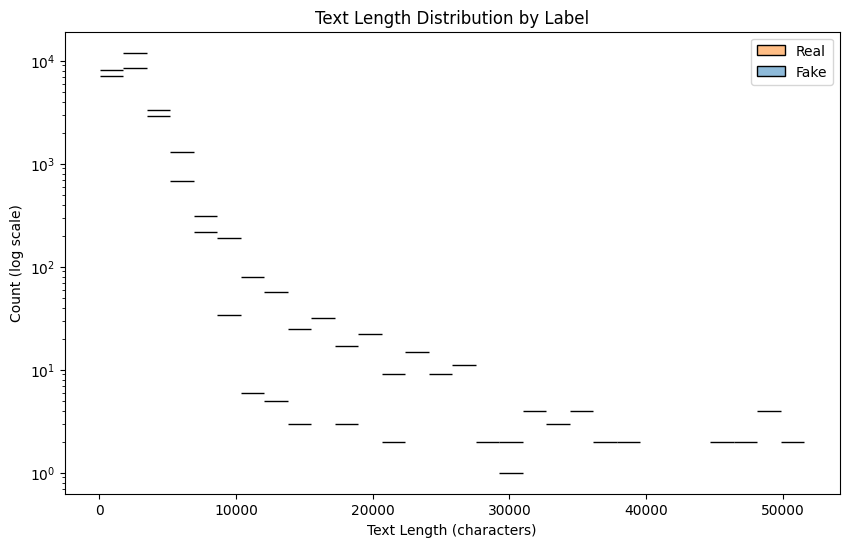

Text length statistics:
         count         mean          std   min     25%     50%     75%  \
label                                                                    
0      21417.0  2439.876173  1678.425520  30.0   977.0  2278.0  3287.0   
1      23472.0  2624.662065  2520.052044  29.0  1518.0  2241.0  3104.0   

           max  
label           
0      29835.0  
1      51592.0  


In [9]:
# Visualize text length distribution
df['text_length'] = df['processed_text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='label', bins=30, log_scale=(False, True))
plt.title('Text Length Distribution by Label')
plt.xlabel('Text Length (characters)')
plt.ylabel('Count (log scale)')
plt.legend(['Real', 'Fake'])
plt.show()

# Display statistics
print("Text length statistics:")
print(df.groupby('label')['text_length'].describe())

## 5. Split Data into Train, Validation, and Test Sets

In [10]:
# Split data into train, validation, and test sets
# First, split into train+val and test
train_val_df, test_df = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df['label']
)

# Then split train+val into train and validation
train_df, val_df = train_test_split(
    train_val_df, test_size=0.15, random_state=SEED, stratify=train_val_df['label']
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Check label distribution in each split
print("\nLabel distribution in training set:")
print(train_df['label'].value_counts(normalize=True))

print("\nLabel distribution in validation set:")
print(val_df['label'].value_counts(normalize=True))

print("\nLabel distribution in test set:")
print(test_df['label'].value_counts(normalize=True))

Training set size: 30524
Validation set size: 5387
Test set size: 8978

Label distribution in training set:
label
1    0.522867
0    0.477133
Name: proportion, dtype: float64

Label distribution in validation set:
label
1    0.522926
0    0.477074
Name: proportion, dtype: float64

Label distribution in test set:
label
1    0.522945
0    0.477055
Name: proportion, dtype: float64


## 6. Create PyTorch Dataset for the Model

In [11]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        # Convert to tensors and remove batch dimension the tokenizer adds
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

## 7. Load DistilBERT Model and Tokenizer

In [12]:
# Model configuration
MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 512
BATCH_SIZE = 8

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Create datasets
train_dataset = FakeNewsDataset(
    train_df['processed_text'].tolist(),
    train_df['label'].tolist(),
    tokenizer,
    max_length=MAX_LENGTH
)

val_dataset = FakeNewsDataset(
    val_df['processed_text'].tolist(),
    val_df['label'].tolist(),
    tokenizer,
    max_length=MAX_LENGTH
)

test_dataset = FakeNewsDataset(
    test_df['processed_text'].tolist(),
    test_df['label'].tolist(),
    tokenizer,
    max_length=MAX_LENGTH
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
# Load model for binary classification
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

# Print model summary
print(f"Model: {MODEL_NAME}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: distilbert-base-uncased
Number of parameters: 66955010


## 8. Define Training Arguments and Evaluation Metrics

In [14]:
def compute_metrics(pred):
    """
    Compute metrics for evaluation.
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results_distilbert',
    num_train_epochs=3,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_distilbert',
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)

/opt/miniconda3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>={ACCELERATE_MIN_VERSION}'`

## 9. Train the DistilBERT Model

In [ ]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
print("Starting model training...")
train_start = time.time()
trainer.train()
train_end = time.time()
train_time = train_end - train_start
print(f"Training completed in {train_time:.2f} seconds ({train_time/60:.2f} minutes)")

## 10. Evaluate Model on Test Set

In [ ]:
# Evaluate on test set
print("Evaluating model on test set...")
results = trainer.evaluate(test_dataset)
print("Test results:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

# Get predictions on test set
test_pred_output = trainer.predict(test_dataset)
test_preds = test_pred_output.predictions.argmax(-1)
test_labels = test_pred_output.label_ids

# Create confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['Real', 'Fake']))

## 11. Memory Usage and Performance Analysis

In [ ]:
# Helper function to measure memory usage
def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 * 1024)

# Create pipeline for inference
from transformers import pipeline
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Memory before
mem_before = get_memory_usage()

# Measure inference time on sample texts
sample_texts = test_df['processed_text'].head(50).tolist()
start_time = time.time()
for text in sample_texts:
    _ = classifier(text[:512])
end_time = time.time()

# Memory after
mem_after = get_memory_usage()
mem_used = mem_after - mem_before

avg_inference_time = (end_time - start_time) / len(sample_texts)

print(f"Average inference time: {avg_inference_time:.4f} seconds per sample")
print(f"Memory usage during inference: {mem_used:.2f} MB")

# Add these to a metrics dictionary
model_metrics = {
    "model_name": "DistilBERT",
    "accuracy": results["eval_accuracy"],
    "f1_score": results["eval_f1"],
    "precision": results["eval_precision"],
    "recall": results["eval_recall"],
    "avg_processing_time": avg_inference_time,
    "avg_memory_usage": mem_used,
    "parameter_count": sum(p.numel() for p in model.parameters())
}

## 12. Save Model and Metrics for Django Integration

In [ ]:
# Save model
MODEL_OUTPUT_DIR = "./models/distilbert_fakenewsnet"
trainer.save_model(MODEL_OUTPUT_DIR)
tokenizer.save_pretrained(MODEL_OUTPUT_DIR)
print(f"Model saved to {MODEL_OUTPUT_DIR}")

# Save metrics
METRICS_OUTPUT_PATH = "./models/distilbert_fakenewsnet_metrics.json"
with open(METRICS_OUTPUT_PATH, 'w') as f:
    json.dump(model_metrics, f, indent=4)
print(f"Model metrics saved to {METRICS_OUTPUT_PATH}")

## 13. Example of How to Use the Model in Django

In [ ]:
# Test the model with a few examples
examples = [
    "Scientists discover breakthrough treatment for cancer that pharmaceutical companies don't want you to know about.",
    "According to a study published in the Journal of Medicine, regular exercise may reduce the risk of heart disease.",
    "Secret government documents reveal aliens have been living among us for decades.",
    "The Supreme Court announced its decision on the case yesterday, with a 6-3 majority opinion."
]

for example in examples:
    result = classifier(example)
    label = result[0]['label']
    score = result[0]['score']
    
    # Convert label index to text
    label_text = "Fake" if "LABEL_1" in label else "Real"
    
    print(f"Text: {example}")
    print(f"Prediction: {label_text} (confidence: {score:.4f})")
    print("---")

In [ ]:
# Code to integrate with Django (example for services.py)
def analyze_with_distilbert(text, model_dir="./models/distilbert_fakenewsnet"):
    """
    Analyze text using the DistilBERT model.
    
    Args:
        text: Text to analyze
        model_dir: Path to the saved model directory
        
    Returns:
        dict: Detection results
    """
    # Import the required libraries (inside the function to avoid loading at startup)
    import time
    import torch
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    
    # Create pipeline
    device = 0 if torch.cuda.is_available() else -1
    classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, device=device)
    
    # Measure performance
    start_time = time.time()
    result = classifier(text[:512])[0]
    processing_time = time.time() - start_time
    
    # Map the result
    label = result['label']
    score = result['score']
    
    # In this model, LABEL_0 = real, LABEL_1 = fake
    if "LABEL_0" in label:
        credibility_score = score
        category = "credible" if score > 0.7 else "mixed"
    else:
        credibility_score = 1 - score
        category = "fake" if score > 0.7 else "mixed"
    
    return {
        "credibility_score": credibility_score,
        "category": category,
        "confidence": score,
        "model_name": "DistilBERT",
        "processing_time": processing_time
    }

## 14. Compare with TinyBERT (If Available)

In [ ]:
# If you've also trained TinyBERT, load its metrics for comparison
try:
    with open("./models/tinybert_fakenewsnet_metrics.json", 'r') as f:
        tinybert_metrics = json.load(f)
    
    # Create comparison table
    metrics_comparison = pd.DataFrame({
        'DistilBERT': [
            model_metrics['accuracy'],
            model_metrics['f1_score'],
            model_metrics['precision'],
            model_metrics['recall'],
            model_metrics['avg_processing_time'],
            model_metrics['avg_memory_usage'],
            model_metrics['parameter_count']
        ],
        'TinyBERT': [
            tinybert_metrics['accuracy'],
            tinybert_metrics['f1_score'],
            tinybert_metrics['precision'],
            tinybert_metrics['recall'],
            tinybert_metrics['avg_processing_time'],
            tinybert_metrics['avg_memory_usage'],
            tinybert_metrics['parameter_count']
        ]
    }, index=[
        'Accuracy',
        'F1 Score',
        'Precision',
        'Recall',
        'Avg. Processing Time (s)',
        'Memory Usage (MB)',
        'Parameter Count'
    ])
    
    display(metrics_comparison)
    
    # Visualize comparison
    # Performance metrics
    performance_metrics = metrics_comparison.iloc[:4]
    plt.figure(figsize=(10, 6))
    performance_metrics.plot(kind='bar', ax=plt.gca())
    plt.title('Performance Metrics Comparison')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()
    
    # Resource usage
    resource_metrics = metrics_comparison.iloc[4:6]
    plt.figure(figsize=(10, 6))
    resource_metrics.plot(kind='bar', ax=plt.gca())
    plt.title('Resource Usage Comparison')
    plt.ylabel('Value')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"TinyBERT metrics not available for comparison: {e}")
    print("Complete the TinyBERT notebook first to enable model comparison.")

## 15. Next Steps

1. Train models on the LIAR dataset (see the LIAR dataset notebook)
2. Compare the performance between models trained on FakeNewsNet and LIAR
3. Select the best performing model for your Django application
4. Integrate the model into your Django application using the provided code

### Django Integration Tips

1. Install PyTorch and Transformers in your Django environment
2. Copy the saved model to a directory accessible by your Django app
3. Use the `analyze_with_distilbert` function in your `services.py` file
4. Initialize the model once in a worker or use lazy loading to avoid startup delays
5. Consider using a message queue (Celery) for asynchronous processing of large articles